In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/oxape/.fastai/data/camvid/labels'),
 PosixPath('/home/oxape/.fastai/data/camvid/images'),
 PosixPath('/home/oxape/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/oxape/.fastai/data/camvid/valid.txt')]

In [31]:
path/'valid.txt'

PosixPath('/home/oxape/.fastai/data/camvid/valid.txt')

In [4]:
URLs.CAMVID

'https://s3.amazonaws.com/fast-ai-imagelocal/camvid'

In [5]:
path_lbl = path/'labels'
path_img = path/'images'

# Data

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/oxape/.fastai/data/camvid/images/0016E5_06720.png'),
 PosixPath('/home/oxape/.fastai/data/camvid/images/0006R0_f03000.png'),
 PosixPath('/home/oxape/.fastai/data/camvid/images/0016E5_01740.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/oxape/.fastai/data/camvid/labels/0016E5_07860_P.png'),
 PosixPath('/home/oxape/.fastai/data/camvid/labels/0016E5_07320_P.png'),
 PosixPath('/home/oxape/.fastai/data/camvid/labels/0001TP_009600_P.png')]

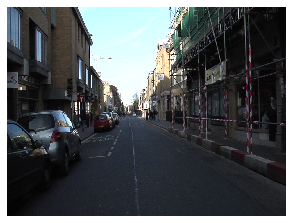

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [18]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

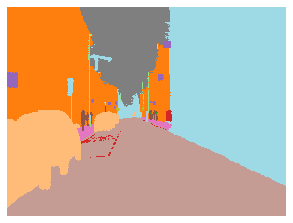

In [20]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1) # 标签是每个像素对应一个数字

In [21]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]),
 tensor([[[ 4,  4,  4,  ..., 30, 30, 30],
          [ 4,  4,  4,  ..., 30, 30, 30],
          [ 4,  4,  4,  ..., 30, 30, 30],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [25]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes # 这个数组的index代表标签中每个像素值对应的含义

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

# Datasets

In [35]:
size = src_size//2
print(size)

free = gpu_mem_get_free_no_cache()
if free > 8200: 
    bs = 8
else:
    bs = 4
print(f'using bs={bs}, have {free}MB of GPU RAM free')

[360 480]
using bs=8, have 10803MB of GPU RAM free


In [33]:
size

array([360, 480])

In [32]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn, classes=codes)) # valid.txt里有验证集的文件名称列表

In [39]:
print(imagenet_stats) # 这里应该是imagenet整个数据集的方差和平均值
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs).
        normalize(imagenet_stats))

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


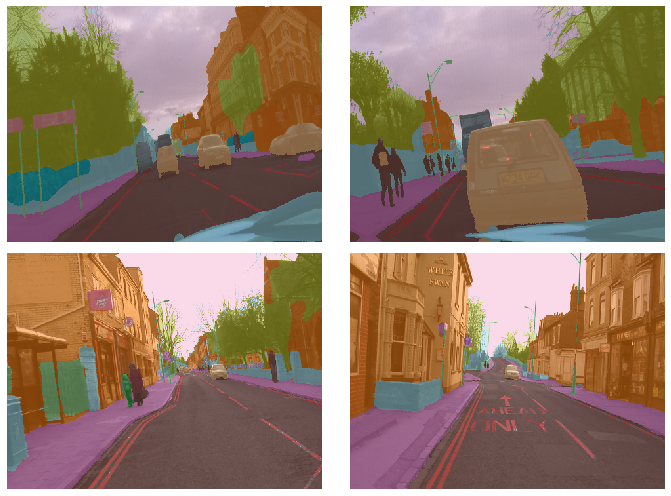

In [40]:
data.show_batch(2, figsize=(10, 7))

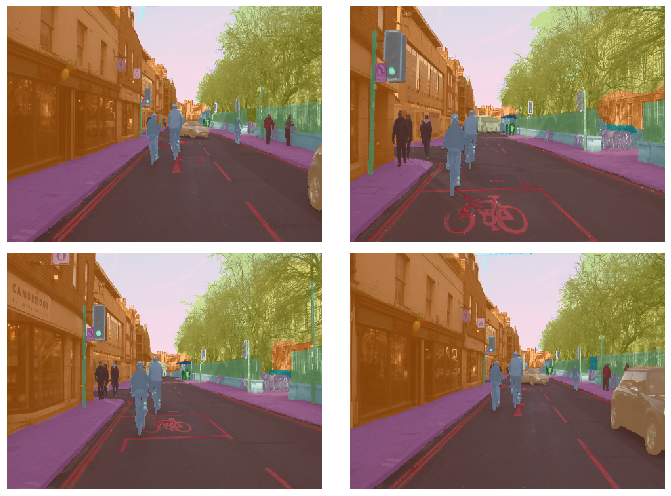

In [41]:
data.show_batch(2, figsize=(10, 7), ds_type=DatasetType.Valid)

# Model

In [60]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1) # array(1, 10).squeeze = array(10)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean() # argmax难道模型输出是每个像素值输出一个oneshot编码的数组？

In [61]:
metrics = acc_camvid

In [62]:
wd=1e-2 # 科学计数法
print(wd)

0.01


In [63]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


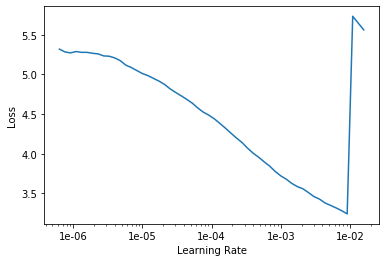

In [64]:
lr_find(learn)
learn.recorder.plot()

In [65]:
lr=1e-4

In [66]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,3.592010,2.898376,0.430036,00:45
1,2.307324,1.554563,0.611294,00:43
2,1.375471,0.850484,0.794010,00:43
3,0.980315,0.740501,0.821660,00:43
4,0.818862,0.639101,0.838587,00:43
5,0.725353,0.592389,0.846205,00:43
6,0.652969,0.586106,0.832844,00:43
7,0.608000,0.512382,0.860288,00:43
8,0.545126,0.469013,0.871521,00:43
9,0.490407,0.413627,0.883808,00:43


In [67]:
learn.save('stage-1')

In [70]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/oxape/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/oxape/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

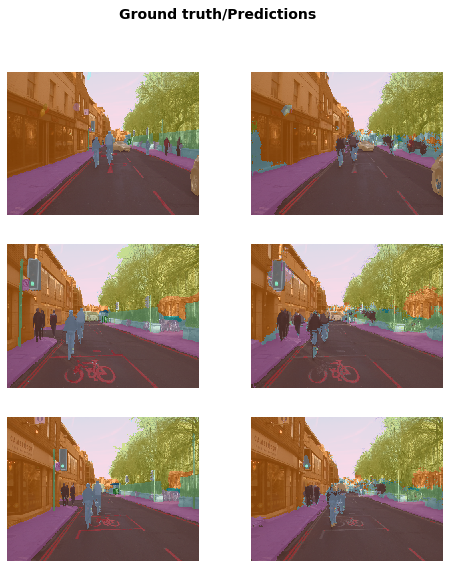

In [74]:
learn.show_results(rows=3, figsize=(8, 9))

In [75]:
learn.unfreeze()

In [76]:
lrs = slice(lr/400, lr/4)

In [78]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.445816,0.403783,0.885283,00:45
1,0.445885,0.403800,0.883935,00:46
2,0.447327,0.405900,0.881470,00:45
3,0.440311,0.398703,0.885218,00:45
4,0.440820,0.396289,0.885278,00:45
5,0.436064,0.387911,0.886445,00:45
6,0.423395,0.391329,0.886404,00:45
7,0.420141,0.385949,0.887274,00:45
8,0.409280,0.378570,0.889365,00:45
9,0.401182,0.368063,0.893216,00:45


In [79]:
learn.save('stage-2')